## Fractional Differentiation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read sample data

In [2]:
df_prices = pd.read_csv('IBM_unadjusted.txt', names=["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_prices['datetime'] = pd.to_datetime(df_prices['Date']+' '+df_prices['Time'], format='%Y/%m/%d %H:%M', errors='ignore')
ts = df_prices.set_index(pd.DatetimeIndex(df_prices['datetime']))

FileNotFoundError: [Errno 2] File IBM_unadjusted.txt does not exist: 'IBM_unadjusted.txt'

In [3]:
ts.head(5)

,Date,Time,Open,High,Low,Close,Volume,datetime
datetime,,,,,,,,
1998-01-02 09:30:00,01/02/1998,09:30,104.5000,104.5,104.500,104.500,67000,01/02/1998 09:30
1998-01-02 09:31:00,01/02/1998,09:31,104.3750,104.5,104.375,104.375,10800,01/02/1998 09:31
1998-01-02 09:32:00,01/02/1998,09:32,104.4375,104.5,104.375,104.500,13300,01/02/1998 09:32
1998-01-02 09:33:00,01/02/1998,09:33,104.4375,104.5,104.375,104.375,16800,01/02/1998 09:33
1998-01-02 09:34:00,01/02/1998,09:34,104.3750,104.5,104.375,104.375,4801,01/02/1998 09:34


## Functions implemented from the book

In [37]:
def getWeights(d, size):
    w=[1]*size
    for k in range(1, size):
        w[k] = -w[k-1]/ k * (d - k + 1)
    
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def getWeights_FFD(d=0.1, thres=1e-5):    
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff(series, d, thres=0.1):
    w = getWeights(d, series.shape[0])
    w_ = np.cumsum(abs(w))
    w_ /= w[-1]
    skip = w_[w_>thres].shape[0]
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc][0.0])
        df[name]= df_.copy(deep=True)
        
    df = pd.concat(df, axis=1)
    return df

def fracDiff_FFD(series, d, thres=1e-5):
    # this function is not defined, read text to see what exactly he was trying to do
    w = getWeights_FFD(d, thres)
    #w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    
    for name in series.columns: 
        seriesF=series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(dtype='float64') 
        
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs 
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
            df[name] = df_.copy(deep=True) 
            #print (df[name].head(5))
            
    df = pd.concat(df, axis=1)
    
    return df


def fracDiff(series, d, thres=0.1):
    w = getWeights(d, series.shape[0])
    w_ = np.cumsum(abs(w))
    w_ /= w[-1]
    skip = w_[w_>thres].shape[0]
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue
            df_[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc][0.0])
        df[name]= df_.copy(deep=True)
        
    df = pd.concat(df, axis=1)
    return df

def fracDiff_FFD(mat, d, thres=1e-5):
    # this function is not defined, read text to see what exactly he was trying to do
#     w = getWeights_FFD(d, thres)
    w = getWeights_FFD(d, thres)
    print("shape w:",w.shape)
    w= np.array([1,1,1,1])
    print("shape w:",w.shape)
    width = len(w)
    dim_0 = mat.shape[0] - len(w)+1
    dim_1 = mat.shape[1]
    # print(dim_0, dim_1)
    ffd = np.zeros((dim_0, dim_1))
    print("dim_0", dim_0)
    #     for i in tqdm_notebook(range(dim_0)):
    for i in range(dim_0):
        ffd[i] = np.dot(w.T,mat[i : width + i])
    print("shape of ffd mat {}".format(ffd.shape))
    return ffd



In [38]:
fracDiff_FFD(a,0.35)

shape w: (1826, 1)
shape w: (4,)
dim_0 3
shape of ffd mat (3, 3)


array([[3., 4., 5.],
       [2., 3., 4.],
       [3., 4., 5.]])

In [39]:
a =np.array([[1,2,3],[0,0,0],[1,1,1],[1,1,1],[0,1,2],[1,1,1]])
b= np.array([1,1,1,1])
print(b.shape)
np.dot(b.T,a[0:4])

(4,)


array([3, 4, 5])

In [42]:
a

array([[1, 2, 3],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 2],
       [1, 1, 1]])

In [48]:
ffd = fracDiff_FFD(a,0.35)
np.append(a[-len(ffd):],ffd,axis=1)

shape w: (1826, 1)
shape w: (4,)
dim_0 3
shape of ffd mat (3, 3)


array([[1., 1., 1., 3., 4., 5.],
       [0., 1., 2., 2., 3., 4.],
       [1., 1., 1., 3., 4., 5.]])

In [47]:
a

array([[1, 2, 3],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 2],
       [1, 1, 1]])

In [25]:
a[0:3]

array([[1, 2, 3],
       [0, 0, 0],
       [1, 1, 1]])

In [15]:
file_path_x = '../data/test_features/X_test_data.npy'
x_full = np.load(file_path_x)
x_full.shape

(490, 100, 9)

### Example of weigths 

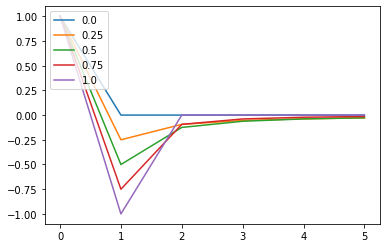

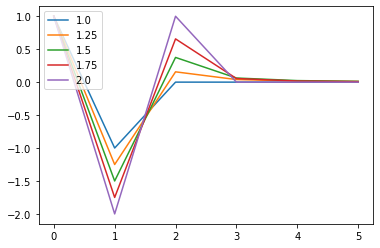

In [5]:
def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
        
    ax = w.plot()
    ax.legend(loc='upper left')
    #mpl.show()
    return

plotWeights(dRange=[0, 1], nPlots=5, size=6)
plotWeights(dRange=[1, 2], nPlots=5, size=6)

## Time series plot of IBM

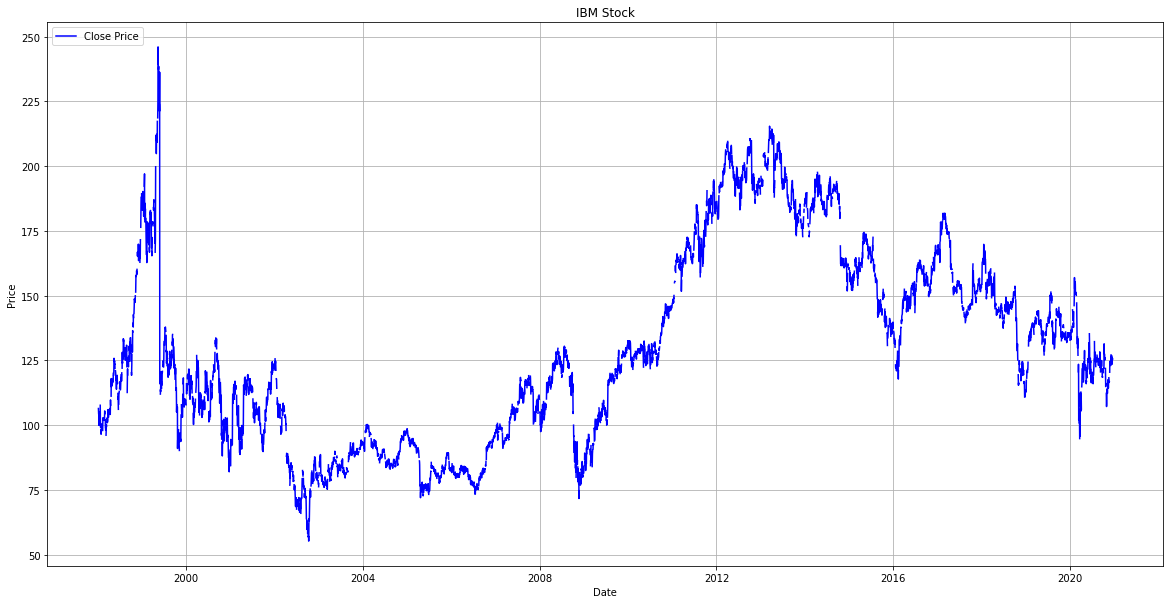

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

ts_sub = ts[['Close',]].resample('1D', label='right').last()
ax.plot(ts_sub.index, ts_sub.Close, color='blue', label='Close Price')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('IBM Stock')
ax.grid(True)
ax.legend(loc='upper left');

## Time series plot fractionally differntiated IBM with d=0.35
Book says d=0.35 is sufficient to remove memory from e-mini

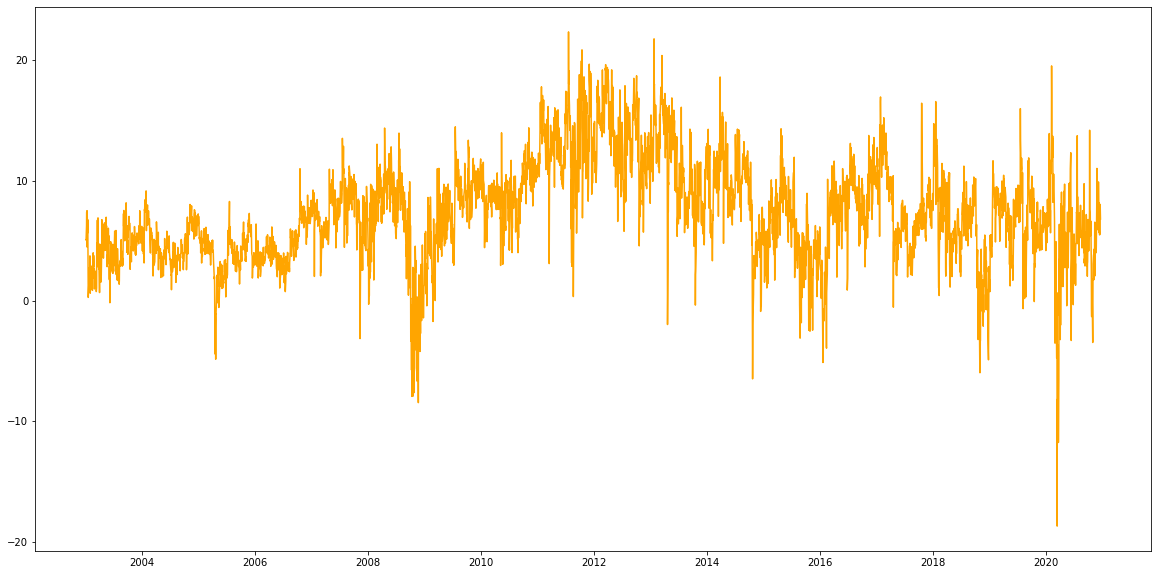

In [7]:
ts_frac_diff = fracDiff_FFD(ts_sub[['Close',]], 0.35)
ts_frac_diff

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ts_frac_diff.index, ts_frac_diff.Close, color='orange', label='Close Price')